In [1]:
# IMPORTE
import numpy
import pandas as pd
import re
import os
from pprint import pprint
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

stoplist = pd.read_csv('stopwords-de.txt', header=None)[0].values.tolist()


In [2]:
# LOAD DATA

name = 'dnb_all_visionen23'
filename = name+'.txt'
dfimport = pd.read_csv(filename, sep="|")

commentframe = dfimport['text']
data = commentframe.values.tolist()
print(len(data))
print(data[1])

244
Bibliotheken der Zukunft sollten "alles" anbieten. Es wird immer Menschen geben, die Bücher in Papier in der Hand halten möchten. E-Book-Reader sind platzsparend und eine gute Ergänzung. Interaktive Medien könnten interessant sein. Weiterhin auch gerne CDs, DVDs, Hörbücher. Schöne Lesebereiche können locken.


In [3]:

# Load spaCy model

nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])
# Assuming 'stoplist' contains your list of stopwords
stoplist = pd.read_csv('stopwords-de.txt', header=None)[0].values.tolist()

# Tokenize and lemmatize the comments, excluding stopwords
data_words_nostops = []

for comment in data:
    # Tokenize the comment using spaCy
    doc = nlp(comment)
    
    # Extract lemmatized words excluding stopwords
    processed_words = [token.lemma_ for token in doc if token.lemma_ not in stoplist]
    
    data_words_nostops.append(processed_words)

In [4]:

# Lemmatisierung
def lemmatization(texts, allowed_postags=['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']):
  texts_out = []
  for sent in texts:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out


data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'])
#print('lemmata: ' + str(data_lemmatized[:9]))

# Lemmatisierte Daten erneut durch Stoplist schleifen
#data_final = [[word for word in doc if len(word) > 2 and word not in stoplist] for doc in data_lemmatized]



In [5]:
# Lemmatisierte Daten erneut durch Stoplist schleifen
data_final = [[word for word in doc if len(word) > 2 and word not in stoplist] for doc in data_lemmatized]
print(data_final[1])

['Bibliothek', 'Zukunft', 'anbieten', 'Mensch', 'geben', 'Buch', 'Papier', 'Hand', 'halten', 'E-Book-Reader', 'platzsparend', 'Ergänzung', 'Interaktive', 'Medium', 'interessant', 'weiterhin', 'gerne', 'DVDs', 'Hörbücher', 'schön', 'Lesebereich', 'locken']


In [6]:
type(data_final)

list

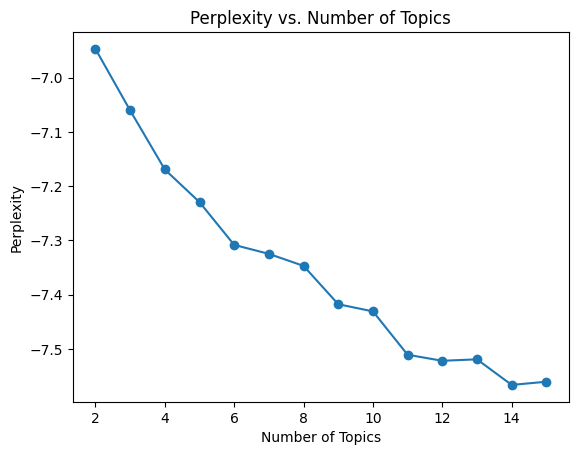

In [7]:
# elbow method to approximate sufficiant number of topics

import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Assuming 'corpus' is your document-term matrix and 'id2word' is the mapping from word ids to words
# You may need to replace 'num_topics_range' with the range of values you want to explore

num_topics_range = range(2, 16)
perplexity_values = []
id2word = corpora.Dictionary(data_final)
corpus = [id2word.doc2bow(text) for text in data_final]

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42) # CAUTION!
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_values.append(perplexity)

# Plotting the results
plt.plot(num_topics_range, perplexity_values, marker='o')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.savefig('TopicNumElbow.svg')
plt.show()


In [8]:
# TRAINING

num_topics = 11 # Anzahl der Themen, nach denen die Daten gegliedert werden sollen, Zahl kann frei geändert werden
chunks = len(data)

#id2word = corpora.Dictionary(data_final)
#print('id2word: '+str(id2word))

#corpus = [id2word.doc2bow(text) for text in data_final]
#print('corpus: '+str(corpus))

lda_model = gensim.models.ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100,
   update_every=1, chunksize=chunks, passes=10, alpha='auto', per_word_topics=True
)

#pprint(lda_model.print_topics(num_topics=50))
pprint(lda_model.print_topics(num_topics))

doc_lda = lda_model[corpus]


print('\nPerplexity: ', lda_model.log_perplexity(corpus))

[(0,
  '0.030*"Raum" + 0.018*"Ope" + 0.018*"Zukunft" + 0.013*"Zusammenarbeit" + '
  '0.012*"positiv" + 0.012*"bringen" + 0.012*"Welt" + 0.012*"neu" + '
  '0.012*"Treffpunkt" + 0.012*"Idee"'),
 (1,
  '0.050*"Buch" + 0.026*"Bibliothek" + 0.013*"Geschichte" + 0.013*"Zukunft" + '
  '0.013*"Kaffee" + 0.013*"Papier" + 0.013*"Pflanze" + 0.007*"Mensch" + '
  '0.007*"digital" + 0.007*"Chance"'),
 (2,
  '0.027*"Buch" + 0.014*"Bibliothek" + 0.014*"geben" + 0.014*"Cloud" + '
  '0.014*"beamen" + 0.014*"Kind" + 0.014*"Frieden" + '
  '0.014*"Nationalbibliothek" + 0.007*"Ort" + 0.007*"sichtbar"'),
 (3,
  '0.025*"DNB" + 0.017*"Bestand" + 0.009*"wissenschaftlich" + 0.009*"-große" + '
  '0.009*"Leben" + 0.009*"Schatten" + 0.009*"digital" + 0.009*"lesen" + '
  '0.009*"Weg" + 0.009*"Kind"'),
 (4,
  '0.047*"Bibliothek" + 0.043*"Buch" + 0.039*"Zukunft" + 0.018*"Ort" + '
  '0.011*"Gedächtnis" + 0.011*"Digital" + 0.011*"echt" + 0.011*"zugänglich" + '
  '0.010*"lesen" + 0.007*"DNB"'),
 (5,
  '0.042*"Bibliothek"

In [9]:
# Define a mapping from topic numbers to labels
topic_labels = {
    0: "Zusammenarbeit Treffpunkt",
    1: "Kaffee",
    2: "Cloud",
    3: "Bestand Wissenschaft",
    4: "Gedächtnis",
    5: "Treffpunkt Bibliothek Museum",
    6: "Buch Galaxie",
    7: "Vergangenheit",
    8: "offener Zugang",
    9: "Digitalisierung",
    10: "Bewahren Verknüpfen"
}

In [10]:
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, name + 'LDATopics' + '_' + '.html') #_prechunked'+ str(prechunks)

In [11]:
from gensim.models import ldaseqmodel

def assign_topic(lda_model, corpus):
    topics = lda_model.get_document_topics(corpus)
    dominant_topics = [max(t, key=lambda x: x[1])[0] for t in topics]
    return dominant_topics

document_topics = assign_topic(lda_model, corpus)

In [12]:
# writing topic assignment into csv together with all docs

import csv

# Assuming you have document_texts, document_topics, and clusters from the previous steps

# Create a list to store the data
data_n = []

# Iterate through documents and their corresponding topics and clusters
for doc_num, (doc_text, topic) in enumerate(zip(commentframe, document_topics)):
    data_n.append([doc_num, topic, doc_text])

# Write data to CSV file
csv_file_path = name+"_topics_clusters.csv"
with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write headers
    writer.writerow(["docnum", "topicnum", "text"])
    # Write data
    writer.writerows(data_n)


In [13]:
# adding topic labels and writing to csv

import pandas as pd

# Read CSV into DataFrame
df = pd.read_csv(name+"_topics_clusters.csv")

# Add a new column 'TopicLabel' to the DataFrame
df['TopicLabel'] = df['topicnum'].map(topic_labels)

# Write the updated DataFrame to a new CSV file
df.to_csv(name+"_topics_clusters_with_labels.csv", index=False)


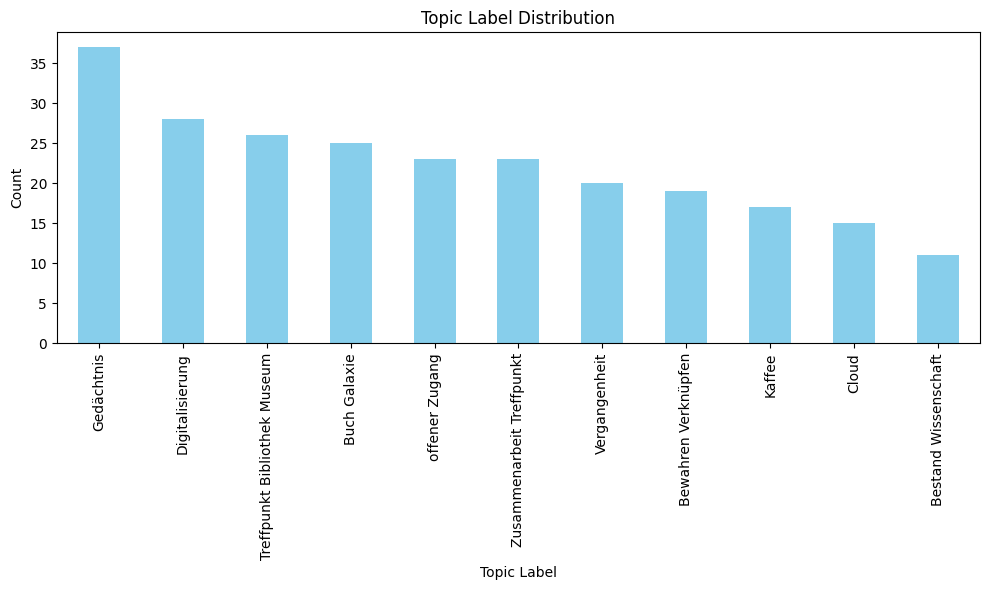

In [19]:
# generating barcharts showing document distribution per topic
dfbar = pd.read_csv(name+"_topics_clusters_with_labels.csv")

topic_label_counts = dfbar['TopicLabel'].value_counts()

plt.figure(figsize=(10, 6))
topic_label_counts.plot(kind='bar', color='skyblue')
plt.title('Topic Label Distribution')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(name+"_DocsPerTopic_barchart.svg")
plt.show()


In [14]:
# generating barcharts showing document distribution per topic
dfbar = pd.read_csv(name+"_topics_clusters_with_labels.csv")
dfbar

,docnum,topicnum,text,TopicLabel
0,0,10,Für DNB heißt mehr Jahre mehr Bücher. Mehr Büc...,Bewahren Verknüpfen
1,1,5,"Bibliotheken der Zukunft sollten ""alles"" anbie...",Treffpunkt Bibliothek Museum
2,2,5,Nach wie vor starke Partnerin der ZDB,Treffpunkt Bibliothek Museum
3,3,9,"Fliegende Bücher, so nach Art Sushi Bar",Digitalisierung
4,4,6,"Ein neues Medium, ein paar Erweiterungen, neue...",Buch Galaxie
...,...,...,...,...
239,239,7,"Riesen-Bücherregal, Sitzsäcke, Ruhe, tolle Sachen",Vergangenheit
240,240,0,Nischenthemen bleiben lieber keine solchen,Zusammenarbeit Treffpunkt
241,241,4,Die Bibliothek der Zukunft als eine interaktiv...,Gedächtnis
242,242,7,Bücher gehören hoffentlich nicht der Vergangen...,Vergangenheit


In [15]:
# determine word frequencies

import pandas as pd
from collections import Counter
import re


def get_word_frequencies_from_list_of_lists(list_of_lists):
    # Concatenate all words from the list of lists into a single list
    all_words = [word for sublist in list_of_lists for word in sublist if word != '--']

    # Calculate word frequencies using Counter
    word_frequencies = Counter(all_words)

    return word_frequencies

# Example usage
frequencies = get_word_frequencies_from_list_of_lists(data_final)

# Print word frequencies
for word, frequency in frequencies.items():
    print(f"{word}: {frequency}")


DNB: 17
heißen: 1
Jahr: 6
Buch: 57
geben: 9
aufbewahren: 2
Bibliothek: 61
Zukunft: 27
anbieten: 3
Mensch: 16
Papier: 7
Hand: 2
halten: 2
E-Book-Reader: 1
platzsparend: 1
Ergänzung: 1
Interaktive: 1
Medium: 6
interessant: 1
weiterhin: 6
gerne: 3
DVDs: 1
Hörbücher: 4
schön: 3
Lesebereich: 1
locken: 1
stark: 2
Partnerin: 1
ZDB: 1
fliegend: 1
Art: 2
Sushi: 1
Bar: 1
neu: 7
Erweiterung: 1
Aufbewahrungsmöglichkeit: 1
Kooperation: 2
Zusammenarbeit: 3
ortsungebund: 1
Zugänglichkeit: 2
Information: 3
bieten: 3
bitte: 2
eröffn: 1
Standort: 2
z.B.: 4
Hamburg: 2
umzuschauen: 1
toll: 7
müs: 1
eröffnen: 1
einladend: 1
Ort: 25
Verweil: 1
Bilrdschirme: 1
schnell: 1
Recherche: 1
Stöber: 1
Lese: 3
Genieße: 1
Gelehrsamkeit: 1
Kommunikation: 2
Meinungsaustausch: 1
Design: 2
Zentraler: 1
Dienstleistungs-)Funktion: 1
Bibliothekswesen: 1
Bundesebene: 1
u.a.: 1
Verknüpfung: 1
Bibltioheke: 1
unterschiedlich: 3
Trägerschaft: 1
wissenschaftlich: 2
Land: 2
öffentlich: 6
meist: 1
Kommune: 1
Fokus: 1
Inhalts-/Sacher

In [16]:
# writing word frequencies to txt

frequencies_file_path = name+'_word_frequencies.txt'

# Example usage
with open(frequencies_file_path, 'w') as file:
    for word, frequency in frequencies.items():
        file.write(f"{word}: {frequency}\n")

print(f"Worthäufigkeiten in folgende Datei geschrieben: {frequencies_file_path}")


Worthäufigkeiten in folgende Datei geschrieben: dnb_all_visionen23_word_frequencies.txt


/home/freybek/envs/jupyterenv/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


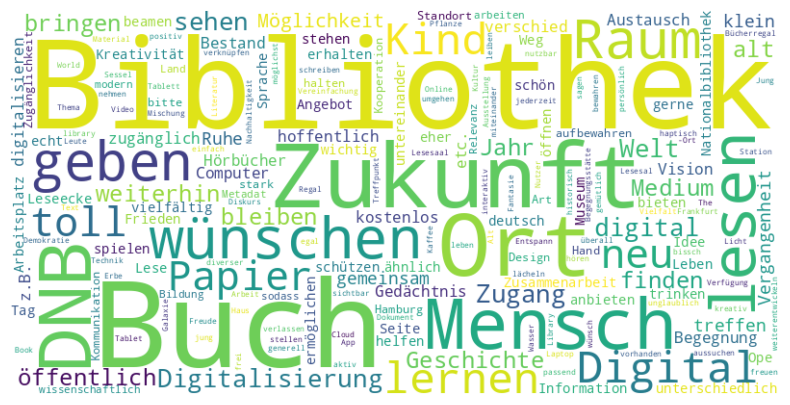

In [17]:
# wordcloud generator

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.savefig(name+'_WordcloudFrequencies.svg')
plt.show()
